<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/PyTorch_Cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install scikit-learn
!pip install torch
!pip install torchvision
!pip install matplotlib

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.1 MB 7.1 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.1 MB 7.1 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/11.1 MB 5.6 MB/s eta 0:00:02
   --------------- ------------------------ 4.2/11.1 MB 5.7 MB/s eta 0:00:02
   ------------------- -------------------- 5.5/11.1 MB 5.7 MB/s eta 0:00:01
   ------------------------ --------------- 6.8/11.1 MB 5.7 MB/s eta 0:00:01
   ----------------------------- ---------- 8.1/11.1 MB 5.8 MB/s eta 0:00:01
   --------------------------------- ------ 9.4/11.1 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 5.9 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)


ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 10.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
   ---------------------------------------- 2.1/204.2 MB 10.7 MB/s eta 0:00:19
    --------------------------------------- 4.5/204.2 MB 11.2 MB/s eta 0:00:18
   - -------------------------------------- 6.8/204.2 MB 11.3 MB/s eta 0:00:18
   - -------------------------------------- 8.9/204.2 MB 11.1 MB/s eta 0:00:18
   -- ------------------------------------- 11.3/204.2 MB 11.0 MB/s eta 0:00:18
   -- ------------------------------------- 13.9/204.2 MB 11.2 MB/s eta 0:00:18
   --- ------------------------------------ 16.3/204.2 MB 11.4 MB/s eta 0:00:17
   --- ------------------------------------ 18.6/204.2 MB 11.4 MB/s eta 0:00:17
   ---- ----------------------------------- 21.2/204.2 MB 11.5 MB/s eta 0:00:16
   ---- ----------------------------------- 23.6/204.2 MB 11.5 MB/s

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from torchvision import transforms


In [5]:
# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root="./cifar-10", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./cifar-10", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False,  num_workers=4, pin_memory=True)

100.0%


In [7]:
classes = train_dataset.classes
print("Classes:", classes)

num_classes = len(classes)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
scaler = torch.amp.GradScaler('cuda',init_scale=2.**16)
criterion = nn.CrossEntropyLoss()

C:\Users\athallah\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [9]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopper = EarlyStopping(patience=5)

In [10]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 4096), nn.ReLU(),
            nn.Linear(4096, 1024), nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, output_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

pytorch_cnn_model = CNN(output_size=10).to(device)

In [11]:
cnn_optimizer = optim.Adam(pytorch_cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = OneCycleLR(
    cnn_optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50
)

In [12]:
def train_cnn(model, optimizer, train_loader, test_loader, scheduler=None, epochs=35):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if scheduler:
                scheduler.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')

        if early_stopper.check_early_stop(test_loss):
            break

    return train_losses, test_losses, train_accs, test_accs

print("Training PyTorch CNN:")
pytorch_cnn_train_loss, pytorch_cnn_test_loss, pytorch_cnn_train_acc, pytorch_cnn_test_acc = train_cnn(
    pytorch_cnn_model, cnn_optimizer, train_loader, test_loader, scheduler=scheduler
)

Training PyTorch CNN:


C:\Users\athallah\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/35 Train Acc: 44.14% Test Acc: 57.51%
Epoch 2/35 Train Acc: 62.80% Test Acc: 67.88%
Epoch 3/35 Train Acc: 70.62% Test Acc: 72.03%
Epoch 4/35 Train Acc: 74.49% Test Acc: 73.34%
Epoch 5/35 Train Acc: 76.75% Test Acc: 76.22%
Epoch 6/35 Train Acc: 78.41% Test Acc: 78.26%
Epoch 7/35 Train Acc: 80.29% Test Acc: 78.10%
Epoch 8/35 Train Acc: 80.95% Test Acc: 78.56%
Epoch 9/35 Train Acc: 81.87% Test Acc: 78.13%
Epoch 10/35 Train Acc: 83.30% Test Acc: 80.66%
Epoch 11/35 Train Acc: 84.33% Test Acc: 81.91%
Epoch 12/35 Train Acc: 84.90% Test Acc: 81.82%
Epoch 13/35 Train Acc: 85.98% Test Acc: 81.48%
Epoch 14/35 Train Acc: 86.09% Test Acc: 82.69%
Epoch 15/35 Train Acc: 86.71% Test Acc: 82.08%
Epoch 16/35 Train Acc: 87.13% Test Acc: 83.25%
Epoch 17/35 Train Acc: 87.45% Test Acc: 83.45%
Epoch 18/35 Train Acc: 87.89% Test Acc: 83.35%
Epoch 19/35 Train Acc: 88.68% Test Acc: 83.54%
Epoch 20/35 Train Acc: 88.50% Test Acc: 83.83%
Epoch 21/35 Train Acc: 89.01% Test Acc: 84.79%
Epoch 22/35 Train Acc:

In [24]:
def evaluate_model(model, test_loader, num_classes=10):
    model.eval()
    y_true, y_pred, y_score = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_score.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    print("\n========= Evaluation Metrics =========")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print("======================================")

    # ROC AUC Score (macro-averaged)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    try:
        auc = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')
        print(f"AUC-ROC  : {auc:.4f}")
    except ValueError as e:
        print("AUC-ROC can't be computed:", e)

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    plt.figure(figsize=(10, 8))
    y_true_binarized = np.eye(output_size)[y_true]
    for i in range(output_size):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], np.array(y_prob)[:, i])
        auc_i = roc_auc_score(y_true_binarized[:, i], np.array(y_prob)[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_i:.4f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-Rest)')
    plt.legend()
    plt.tight_layout()
    plt.show()

#MLP Model

In [15]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

In [16]:
model = MLP()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
def train():
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")



In [18]:
from sklearn.metrics import auc

def evaluate(loader, is_test=True):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"{'Test' if is_test else 'Train'} Accuracy: {acc*100:.2f}%")
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

    # ROC and AUC for multi-class
    y_true = label_binarize(all_labels, classes=list(range(10)))
    y_score = np.array(all_probs)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average AUC
    all_auc = roc_auc_score(y_true, y_score, average='macro', multi_class='ovr')
    print(f"\nMacro-Averaged AUC Score: {all_auc:.4f}")

    # ROC Curve Plot
    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {"Test" if is_test else "Train"} Set')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


Train Accuracy: 8.88%
Precision: 0.0961, Recall: 0.0888, F1 Score: 0.0560

Macro-Averaged AUC Score: 0.5172


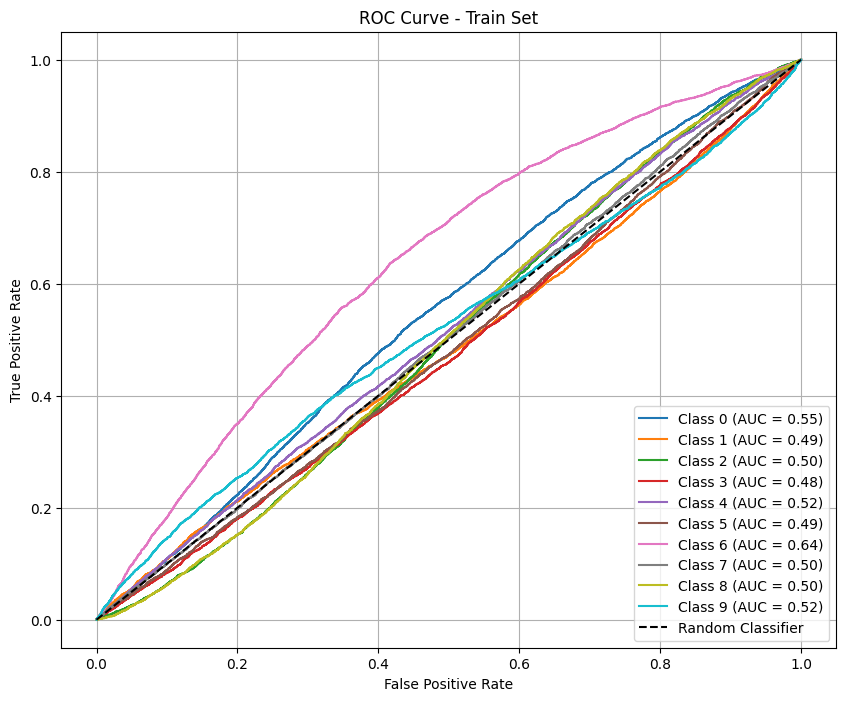

Test Accuracy: 9.09%
Precision: 0.1039, Recall: 0.0909, F1 Score: 0.0593

Macro-Averaged AUC Score: 0.5201


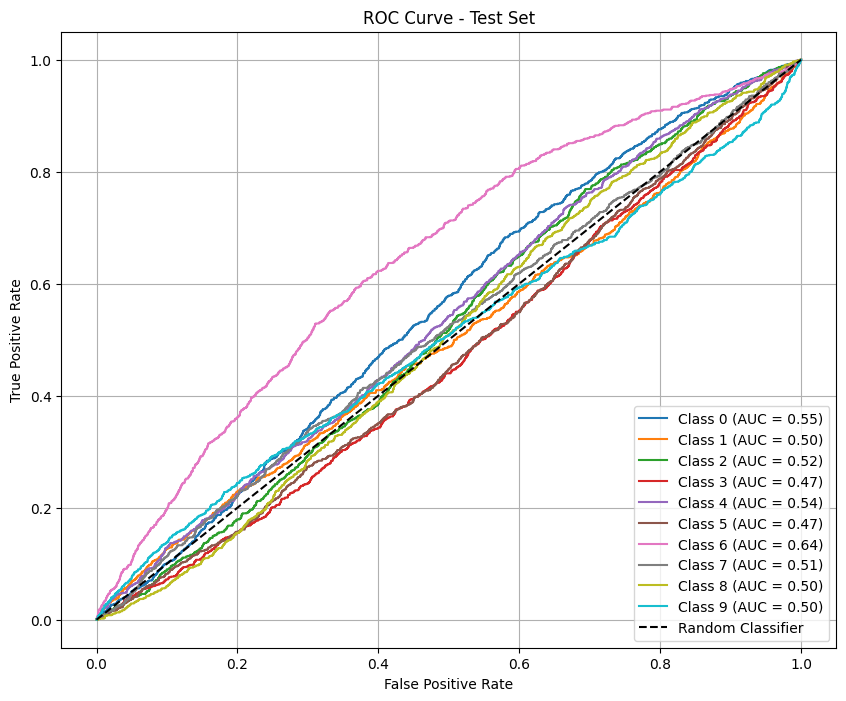

In [21]:
evaluate(train_loader, is_test=False)
evaluate(test_loader, is_test=True)

Perbandingan Matriks Evaluasi

Berikut adalah hasil evaluasi performa model terhadap data pelatihan dan data pengujian:

| Metric           | Train         | Test          |
|------------------|---------------|---------------|
| Akurasi          | 0.0888        | 0.0909        |
| Presisi          | 0.0961        | 0.1039        |
| Recall           | 0.0888        | 0.0909        |
| F1 Score         | 0.0560        | 0.0593        |
| AUC (Macro)      | 0.5172        | 0.5201        |

---

##  Analisis Perbandingan

### Akurasi (Accuracy)

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Akurasi menunjukkan proporsi prediksi yang benar dari keseluruhan jumlah data.  
Pada model ini, baik data pelatihan (8.88%) maupun data pengujian (9.09%) memiliki akurasi yang sangat rendah, hanya sedikit lebih baik dari tebakan acak (sekitar 10% untuk 10 kelas).  
Hal ini menandakan bahwa model belum mampu mempelajari pola dari data dengan baik.

---

### Presisi (Precision)

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Presisi mengukur seberapa banyak dari prediksi positif yang benar.  
Nilai presisi yang rendah (Train: 9.61%, Test: 10.39%) menunjukkan bahwa banyak prediksi positif model yang keliru.

---

### Recall (Sensitivity)

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Recall mencerminkan seberapa baik model dalam menemukan semua instance yang relevan.  
Hasil recall yang rendah di kedua data (Train: 8.88%, Test: 9.09%) menunjukkan model sering gagal mengenali data yang seharusnya diprediksi sebagai positif.

---

### F1 Score

$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

F1 Score adalah rata-rata harmonik dari precision dan recall.  
Nilai yang rendah (Train: 5.60%, Test: 5.93%) menandakan bahwa tidak ada keseimbangan yang baik antara keduanya.  
Model ini kurang andal dalam mendeteksi kelas secara akurat dan konsisten.

---

### AUC (Area Under Curve)

AUC mengukur kemampuan model membedakan antara kelas yang berbeda.  
AUC makro rata-rata digunakan ketika jumlah kelas lebih dari dua dan tidak seimbang.

Nilai AUC yang mendekati 0.5 (Train: 0.5172, Test: 0.5201) menandakan performa model setara dengan tebakan acak, memperkuat bahwa model belum belajar membedakan kelas dengan baik.

---